In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
DATADRIVE = '/home/jupyter/data/'

In [9]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-01'),
    first_days=5,
    ensemble_mode='stack',
    idx_stride=8
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [5]:
X, y = ds_train[0]
X.shape, y.shape

((10, 16, 16), (1, 128, 128))

In [10]:
href = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/202001*.nc')

In [11]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [19]:
href_overlap_times = np.intersect1d(
    ds_train.overlap_times, 
    href.valid_time
)

In [21]:
ds_train.mrms

<xarray.DataArray 'tp' (time: 9, lat: 750, lon: 1376)>
array([[[0.00000000e+00, 1.33129200e-04, 6.65645998e-05, ...,
         6.92271802e-03, 3.72761779e-03, 1.79724436e-03],
        [0.00000000e+00, 0.00000000e+00, 5.32516798e-04, ...,
         9.05278569e-03, 5.12547398e-03, 2.13006719e-03],
        [0.00000000e+00, 2.66258399e-04, 5.99081373e-04, ...,
         8.18744578e-03, 5.99081389e-03, 2.79571302e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05T12:00:00
  * lat        (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon        (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0
    lead_time  timedelta64[ns] 12:00:00

In [20]:
href.sel(valid_time=href_overlap_times)

<xarray.DataArray 'tp' (member: 10, valid_time: 8, lat: 750, lon: 1376)>
dask.array<getitem, shape=(10, 8, 750, 1376), dtype=float32, chunksize=(10, 1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    time        (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-02 ... 2020-01-05T12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-05
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'

In [60]:
class TiggeMRMSHREFDataset(TiggeMRMSDataset):
    def __init__(self, href_dir, **kwargs):
        self.href = xr.open_mfdataset(href_dir)
        self.href = self.href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))
        self.href['valid_time'] = self.href.init_time + self.href.lead_time
        self.href = self.href.swap_dims({'init_time': 'valid_time'})
        self.href.load()
        
        super().__init__(**kwargs)
        
    def _create_rqmask(self, rq_fn):
        """Coarsen radar mask to patch and check for full coverage"""
        rq = xr.open_dataarray(rq_fn).load()
        # Account for padding
#         rq = rq.isel(lat=slice(self.pad_mrms, -self.pad_mrms or None), lon=slice(self.pad_mrms, -self.pad_mrms or None))
#         self.rqmask = rq.coarsen(lat=self.patch_mrms, lon=self.patch_mrms, boundary='trim').min() >= 0
        # RQ mask checks for validity of patch indexed by lower left coordinate
        # Note: lat is oriented reversele, so in "real" coords it's the upper left corner
        self.rqmask = (rq[::-1, ::-1].rolling(
            {'lat': self.patch_mrms}, min_periods=1
        ).min().rolling(
            {'lon': self.patch_mrms}, min_periods=1
        ).min() >=0)[::-1, ::-1]
        
        hrefmask = np.isfinite(self.href).mean(('member', 'valid_time')) == 1
        hrefmask = hrefmask.assign_coords(
            {'lat': self.rqmask.lat.values, 'lon': self.rqmask.lon.values}
        )
        
        self.rqmask *= hrefmask
    
    def _crop_times(self):
        """Crop TIGGE and MRMS arrays to where they overlap"""
        # Make TIGGE file have valid_time as dimension
        valid_time = self.tigge.init_time + self.tigge.lead_time
        self.tigge.coords['valid_time'] = valid_time
        self.tigge = self.tigge.swap_dims({'init_time': 'valid_time'})

        # Compute intersect
        self.overlap_times = np.intersect1d(self.mrms.time, self.tigge.valid_time)

        if self.first_days: # Only select first X days
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[dt.day <= self.first_days]
        if self.val_days: # Split into train and valid based on day of month
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[
                dt.day <= self.val_days if self.split == 'valid' else dt.day > self.val_days
            ]
            
        self.overlap_times = np.intersect1d(
            self.overlap_times, 
            self.href.valid_time
        )
        
        # Apply selection
        self.mrms = self.mrms.sel(time=self.overlap_times)
        self.tigge = self.tigge.sel(valid_time=self.overlap_times)
        self.href = self.href.sel(valid_time=self.overlap_times)
        
    def __getitem__(self, idx, time_idx=None, full_array=False, no_cat=False,  member_idx=None):
        """Return individual sample. idx is the sample id, i.e. the index of self.idxs.
        X: TIGGE sample
        y: corresponding MRMS (radar) sample
        
        **Attention:**
        The self.tigge latitude variable is from ~50-20 degrees, i.e. not from small to large!
        Be careful when transforming indices to actual latitude values! 
        
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()
        time_idx_tmp, lat_idx, lon_idx = self.idxs[idx]
        time_idx = time_idx or time_idx_tmp

        # Get features for given time and patch
        if full_array:  # Return full lats, lons
            lat_slice = slice(0, None)
            lon_slice = slice(0, None)
        else:
#             lat_slice = slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge + self.pad_tigge*2)
#             lon_slice = slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge + self.pad_tigge*2)
            lat_slice = slice(lat_idx-self.pad_tigge, lat_idx + self.patch_tigge + self.pad_tigge)
            lon_slice = slice(lon_idx-self.pad_tigge, lon_idx + self.patch_tigge + self.pad_tigge)
        X = self.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
        if self.ensemble_mode == 'stack':
            X = X.rename({'variable': 'raw_variable'}).stack(variable = ['raw_variable', 'member']).transpose(
                'variable', 'lat', 'lon')
        if self.ensemble_mode == 'random':
            if member_idx is None:
                member_idx = np.random.choice(self.tigge.member)
            X = X.sel(member=member_idx)
        if self.ensemble_mode == 'stack_by_variable':
            X = xr.concat([X.rename({'variable': 'raw_variable'}).sel(raw_variable=self.var_names[i]).stack(variable=['member']).transpose(
                'variable', 'lat', 'lon').drop('raw_variable') for i in self.tigge_vars if 'ens10' in i] + 
           [X.sel(variable=[self.var_names[i] for i in self.tigge_vars if 'ens10' not in i], member=0).transpose(
                'variable', 'lat', 'lon')], 
          'variable')
            
            self.var_stack_idxs = {}
            ind_count = 0
            for i, var in enumerate(self.tigge_vars):
                if 'ens10' in var:
                    self.var_stack_idxs[self.var_names[var]] = ind_count + np.arange(10)
                    ind_count+=10
            for i, var in enumerate(self.tigge_vars):
                if 'ens10' not in var:
                    self.var_stack_idxs[self.var_names[var]] = ind_count + np.arange(1)
                    ind_count+=1
            
        X = X.values
        if hasattr(self, 'const'):  # Add constants
            X = self._add_const(X, lat_slice, lon_slice)
        

        # Get targets
        if full_array:   # Return corresponding MRMS slice; not used currently
            lat_slice = slice(0, len(self.tigge.lat) * self.ratio)
            lon_slice = slice(0, len(self.tigge.lon) * self.ratio)
        else:
            lat_slice = slice(lat_idx * self.ratio, lat_idx * self.ratio + self.patch_mrms)
            lon_slice = slice(lon_idx * self.ratio, lon_idx * self.ratio + self.patch_mrms)
        y = self.mrms.isel(
            time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]  # Add dimension for channel
        if self.pure_sr_ratio:
            X = self._make_sr_X(y)
        if self.cat_bins is not None and not no_cat:
            y = self._categorize(y)
            
        href = self.href.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]
            
        if self.pad_tigge_channel:
            X_crop = X[:,self.pad_tigge:self.pad_tigge + self.patch_tigge, self.pad_tigge:self.pad_tigge + self.patch_tigge]
            X_downsample = resize(X[0:1,:,:], (1, self.patch_tigge, self.patch_tigge))
            X = np.concatenate((X_crop, X_downsample), axis=0)
            self.var_stack_idxs['pad_tigge_channel'] = ind_count + np.arange(1)
            ind_count+=1
            
        return X.astype(np.float32), y.astype(np.float32), href.astype(np.float32)   # [vars, patch, patch]
        

In [61]:
ds = TiggeMRMSHREFDataset(
    href_dir=f'{DATADRIVE}/hrefv2//4km/total_precipitation/202001*.nc',
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-01'),
    first_days=5,
    ensemble_mode='stack',
    idx_stride=8
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [62]:
len(ds.idxs)

1080

In [57]:
len(ds.idxs)

1080

In [46]:
X, y, h = ds[0]

In [47]:
X.shape, y.shape, h.shape

((10, 16, 16), (1, 128, 128), (1, 10, 128, 128))

In [55]:
hrefmask = np.isfinite(ds.href).mean(('member', 'valid_time')) == 1

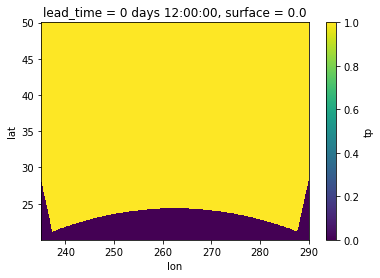

In [63]:
hrefmask.plot()

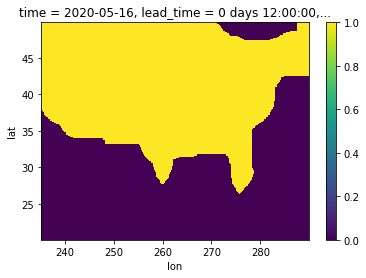

In [64]:
ds.rqmask.plot()